In [21]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pylab as plt
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [22]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.action_count = np.zeros(action_size)
        self.total_steps = 0

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def select_action_ucb(self, state):
        c = 1  # UCB 公式中的探索参数
        q_values = self.model.predict(state)

        # 计算每个动作的 UCB 值
        ucb_values = q_values + c * np.sqrt(np.log(self.total_steps + 1) / (self.action_count + 1))
        action = np.argmax(ucb_values)
        
        # 更新动作计数
        self.action_count[action] += 1
        self.total_steps += 1

        return action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def one_hot_encode(self, state, num_states):
        # Create a zero vector with length equal to the number of states
        one_hot_vector = np.zeros(num_states)
        
        # Set the element at the index of the current state to 1
        one_hot_vector[state] = 1
        
        return one_hot_vector

In [23]:
def Train_Agent(Agent, episodes, rewards, state_size):
    
    for e in range(episodes):

        # Reset the environment at the beginning of each new episode, following the termination of the previous one.
        observation = env.reset()
        state = observation[0]
        one_hot_state = Agent.one_hot_encode(state, state_size)
        state = np.reshape(one_hot_state, [1, state_size])
        terminal = False
        total_reward = 0

        for time in range(5):

            # choose next agent action
            action = Agent.select_action_ucb(state)

            # take action and observe reward
            new_state, reward, terminated, truncated, _ = env.step(action)

            one_hot_new_state = Agent.one_hot_encode(new_state, state_size)
            new_state = np.reshape(one_hot_new_state, [1, state_size])
            Agent.remember(state, action, reward, new_state, terminated)
            
            terminal = terminated or truncated

            # Update state
            state = new_state
            total_reward += reward

            if terminated:
                print("episode: {}/{}, score: {}, e: {:.2}".format(e, episodes, time, agent.epsilon))
                break
            if len(Agent.memory) > 32:
                Agent.replay(32)

        rewards.append(total_reward)
        
    env.close()    
    print(f"Training completed over {episodes} episodes")
    


1/1 [==============================] - 0s 23ms/step
Training completed over 20 episodes


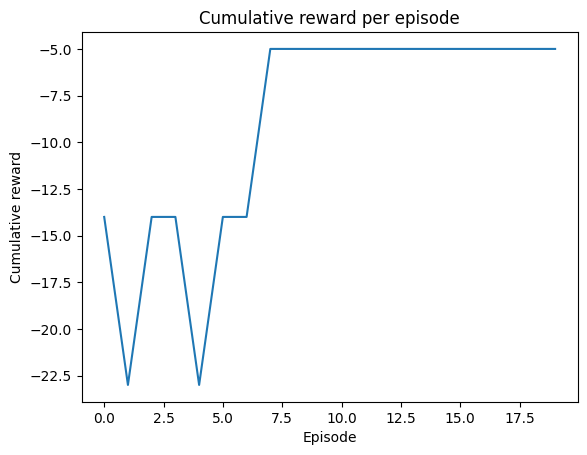

In [24]:
env = gym.make('Taxi-v3')
episodes=20
env.reset()
rewards = []
state_size = env.observation_space.n
action_size = env.action_space.n
Agent=DQNAgent(state_size, action_size)
Train_Agent(Agent,episodes, rewards, state_size)
plt.title("Cumulative reward per episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.plot(rewards)
plt.show()
env.close()